In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet as prophet

In [2]:
from sklearn.preprocessing import minmax_scale

In [3]:
import holidays

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [8]:
%reload_kedro

UsageError: Line magic function `%reload_kedro` not found.


<IPython.core.display.Javascript object>

In [7]:
validaciones_troncal_summary = context.catalog.load(
    "validaciones_troncal_summary@pandas"
)

NameError: name 'context' is not defined

<IPython.core.display.Javascript object>

In [8]:
# dic_estacion_linea = catalog.load("dic_estacion_linea_int")

<IPython.core.display.Javascript object>

In [9]:
validaciones_troncal_summary = validaciones_troncal_summary[
    validaciones_troncal_summary["Estación"].apply(lambda x: len(x.split(")")[0])) == 6
].copy()

<IPython.core.display.Javascript object>

In [10]:
validaciones_troncal_summary["cod_est"] = validaciones_troncal_summary[
    "Estación"
].apply(lambda x: int(x.split(")")[0][1:]))

<IPython.core.display.Javascript object>

In [11]:
validaciones_troncal_summary["date_hour"] = validaciones_troncal_summary.apply(
    lambda row: pd.Timestamp(
        year=row["date"].year,
        month=row["date"].month,
        day=row["date"].day,
        hour=row["Intervalo"].hour,
    ),
    axis=1,
)

<IPython.core.display.Javascript object>

In [12]:
demand_summary = (
    validaciones_troncal_summary[["date_hour", "demand"]].groupby("date_hour").sum()
)

<IPython.core.display.Javascript object>

In [13]:
start_range = min(demand_summary.index)
end_range = max(demand_summary.index)

<IPython.core.display.Javascript object>

In [14]:
complete_index = pd.date_range(start=start_range, end=end_range, freq="1H")

<IPython.core.display.Javascript object>

In [15]:
dates_to_impute = [x for x in complete_index if x not in demand_summary.index]

<IPython.core.display.Javascript object>

In [16]:
for d in dates_to_impute:
    demand_summary.loc[d, "demand"] = 0

<IPython.core.display.Javascript object>

In [17]:
demand_summary = demand_summary.sort_index()

<IPython.core.display.Javascript object>

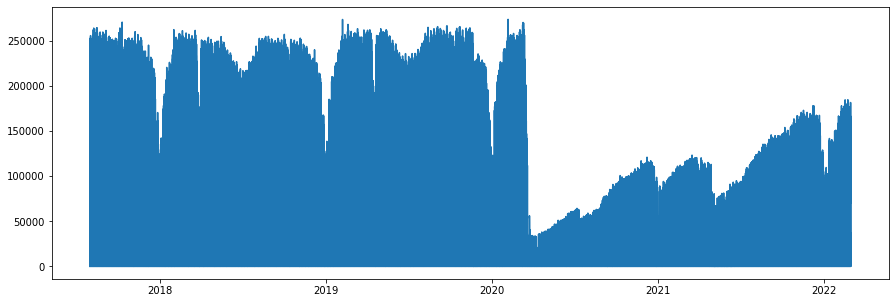

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots()
ax.plot(demand_summary["demand"])
fig.set_size_inches(15, 5)

In [19]:
del validaciones_troncal_summary

<IPython.core.display.Javascript object>

In [20]:
demand_summary.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [21]:
demand_summary_prev = demand_summary[
    demand_summary["date_hour"] < pd.Timestamp(year=2020, month=3, day=20)
].copy()

<IPython.core.display.Javascript object>

In [22]:
demand_summary_prev["hour"] = demand_summary_prev["date_hour"].apply(lambda x: x.hour)

<IPython.core.display.Javascript object>

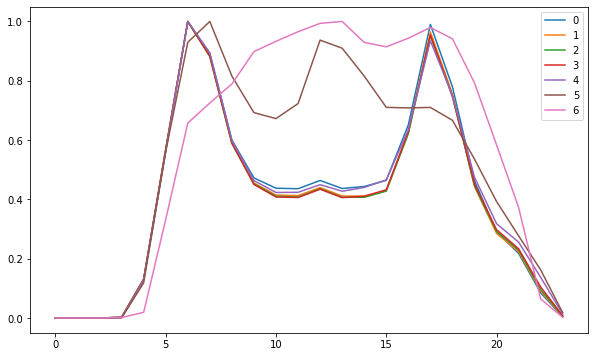

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots()
for i in range(7):
    ax.plot(
        minmax_scale(
            demand_summary_prev[
                demand_summary_prev["date_hour"].apply(lambda x: x.weekday() == i)
            ]
            .groupby("hour")
            .mean()["demand"]
        ),
        label=i,
    )
plt.legend()
fig.set_size_inches(10, 6)

In [24]:
demand_summary_post = demand_summary[
    (demand_summary["date_hour"] > pd.Timestamp(year=2021, month=5, day=4))
    & (demand_summary["date_hour"] < pd.Timestamp(year=2021, month=6, day=1))
].copy()

<IPython.core.display.Javascript object>

In [25]:
demand_summary_post["hour"] = demand_summary_post["date_hour"].apply(lambda x: x.hour)

<IPython.core.display.Javascript object>

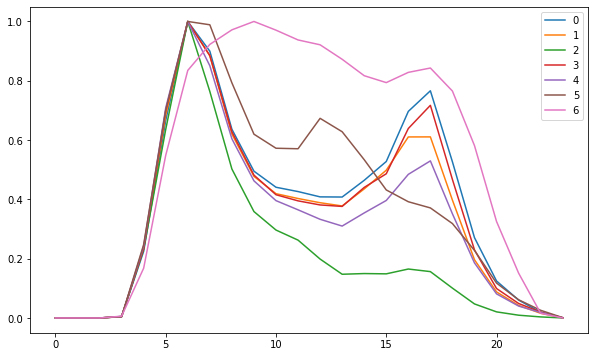

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots()
for i in range(7):
    ax.plot(
        minmax_scale(
            demand_summary_post[
                demand_summary_post["date_hour"].apply(lambda x: x.weekday() == i)
            ]
            .groupby("hour")
            .mean()["demand"]
        ),
        label=i,
    )
plt.legend()
fig.set_size_inches(10, 6)

In [27]:
start_quarantine = pd.Timestamp(year=2020, month=3, day=20)

<IPython.core.display.Javascript object>

In [28]:
start_quarantine_2 = pd.Timestamp(year=2021, month=1, day=15)

<IPython.core.display.Javascript object>

In [57]:
start_quarantine_3 = pd.Timestamp(year=2021, month=4, day=29)

<IPython.core.display.Javascript object>

In [86]:
holidays_df = pd.DataFrame(
    holidays.Colombia(years=list(range(2015, 2025))).items()
).rename({0: "ds", 1: "holiday"}, axis=1)

<IPython.core.display.Javascript object>

In [62]:
demand_summary["holiday"] = demand_summary["date_hour"].apply(
    lambda x: x.date() in holidays.Colombia()
)

<IPython.core.display.Javascript object>

In [30]:
demand_summary["quarantine"] = demand_summary["date_hour"] >= start_quarantine
demand_summary["prev_quarantine"] = demand_summary["date_hour"] < start_quarantine

<IPython.core.display.Javascript object>

In [31]:
demand_summary["sunday"] = demand_summary["date_hour"].apply(lambda x: x.weekday() == 6)
demand_summary["saturday"] = demand_summary["date_hour"].apply(
    lambda x: x.weekday() == 5
)
demand_summary["weekday"] = demand_summary["date_hour"].apply(lambda x: x.weekday() < 5)

<IPython.core.display.Javascript object>

In [78]:
demand_summary["saturday"] = demand_summary["saturday"] & ~demand_summary["holiday"]
demand_summary["sunday"] = demand_summary["sunday"] & ~demand_summary["holiday"]
demand_summary["weekday"] = demand_summary["weekday"] & ~demand_summary["holiday"]

<IPython.core.display.Javascript object>

In [32]:
# demand_summary["weekday_quar"] = (
#    demand_summary["quarantine"] & demand_summary["weekday"]
# )
# demand_summary["weekday_prev_quar"] = (~demand_summary["quarantine"]) & demand_summary[
#    "weekday"
# ]
# demand_summary["sunday_quar"] = demand_summary["quarantine"] & demand_summary["sunday"]
# demand_summary["sunday_prev_quar"] = (~demand_summary["quarantine"]) & demand_summary[
#    "sunday"
# ]
# demand_summary["saturday_quar"] = (
#    demand_summary["quarantine"] & demand_summary["saturday"]
# )
# demand_summary["saturday_prev_quar"] = (~demand_summary["quarantine"]) & demand_summary[
#    "saturday"
# ]

<IPython.core.display.Javascript object>

In [33]:
chgs_base = [start_quarantine, start_quarantine_2, start_quarantine_3]

<IPython.core.display.Javascript object>

In [34]:
start_chgs = demand_summary["date_hour"].min()
end_chgs = demand_summary["date_hour"].max()

<IPython.core.display.Javascript object>

In [35]:
def chgs_from_base(chgs_base, start_chgs, end_chgs):
    chgs_base.sort()
    chgs_base_comp = [start_chgs] + chgs_base + [end_chgs]
    chgs_res = []
    for ch in chgs_base:
        chgs_res += [
            ch,
            ch + pd.Timedelta(value=1, unit="days"),
            ch - pd.Timedelta(value=1, unit="days"),
            ch + pd.Timedelta(value=3, unit="days"),
            ch - pd.Timedelta(value=3, unit="days"),
            ch + pd.Timedelta(value=5, unit="days"),
            ch - pd.Timedelta(value=5, unit="days"),
        ]
    for i in range(len(chgs_base_comp) - 1):
        start_period = chgs_base_comp[i]
        end_period = chgs_base_comp[i + 1]
        dist_periods = (end_period - start_period).days
        num_chgs = int(dist_periods / 180)
        chgs_res += [
            start_period
            + pd.Timedelta(unit="D", value=j * int(dist_periods / (num_chgs + 1)))
            for j in range(1, num_chgs + 1)
        ]
    return chgs_res

<IPython.core.display.Javascript object>

In [36]:
chgs = chgs_from_base(chgs_base, start_chgs, end_chgs)

<IPython.core.display.Javascript object>

In [87]:
model = prophet.Prophet(
    interval_width=0.95,
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=True,
    seasonality_mode="multiplicative",
    changepoints=chgs,
    changepoint_prior_scale=50,
    holidays=holidays_df,
)
# model.add_country_holidays(country_name="CO")

<IPython.core.display.Javascript object>

In [38]:
demand_summary.rename({"date_hour": "ds", "demand": "y"}, axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [39]:
#model.add_seasonality(name='weekly_quarantine', period=7, fourier_order=3, condition_name='quarantine')
#model.add_seasonality(name='weekly_prev_quarantine', period=7, fourier_order=3, condition_name='prev_quarantine')


<IPython.core.display.Javascript object>

In [40]:
# model.add_seasonality(
#    name="weekday_quar", period=1, fourier_order=7, condition_name="weekday_quar"
# )
# model.add_seasonality(
#    name="weekday_prev_quar",
#    period=1,
#    fourier_order=7,
#    condition_name="weekday_prev_quar",
# )
# model.add_seasonality(
#    name="sunday_quar", period=1, fourier_order=7, condition_name="sunday_quar"
# )
# model.add_seasonality(
#    name="sunday_prev_quar",
#    period=1,
#    fourier_order=7,
#    condition_name="sunday_prev_quar",
# )
# model.add_seasonality(
#    name="saturday_quar", period=1, fourier_order=7, condition_name="saturday_quar"
# )
# model.add_seasonality(
#    name="saturday_prev_quar",
#    period=1,
#    fourier_order=7,
#    condition_name="saturday_prev_quar",
# )

<IPython.core.display.Javascript object>

In [88]:
model.add_seasonality(
    name="weekday", period=1, fourier_order=7, condition_name="weekday"
)
model.add_seasonality(name="sunday", period=1, fourier_order=7, condition_name="sunday")
model.add_seasonality(
    name="saturday", period=1, fourier_order=7, condition_name="saturday"
)
model.add_seasonality(
    name="holiday", period=1, fourier_order=7, condition_name="holiday"
)

<IPython.core.display.Javascript object>

In [89]:
model.fit(demand_summary)

Initial log joint probability = -1891.58


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       93030.3     0.0687587       12993.5           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       96015.4    0.00945582       19358.9      0.1733      0.1733      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       96666.4    0.00960517       9392.97           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       96982.3    0.00964554       3692.61           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         97568     0.0740495       7698.37       1.961      0.1961      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

<IPython.core.display.Javascript object>

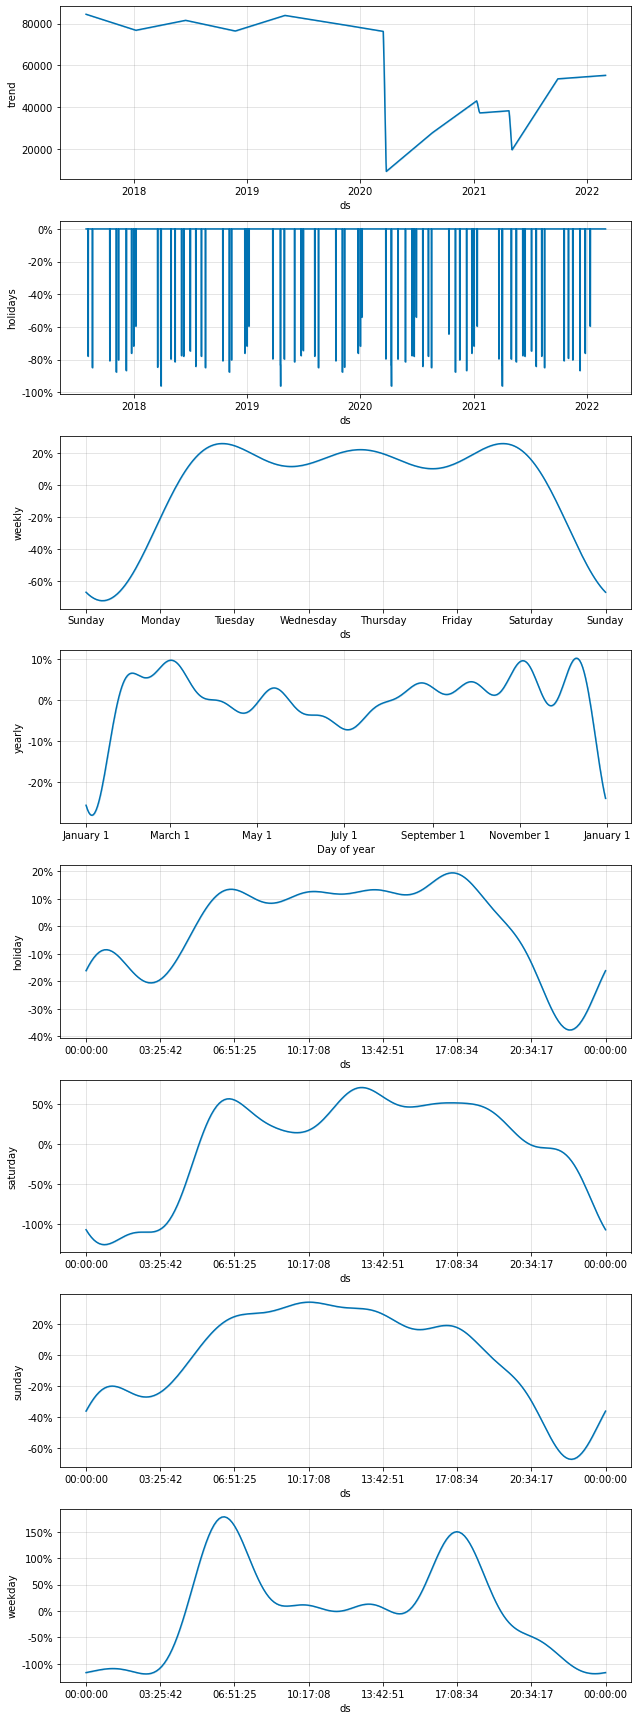

<IPython.core.display.Javascript object>

In [90]:
ax = model.plot_components(model.predict())

In [91]:
pred = demand_summary.copy()

<IPython.core.display.Javascript object>

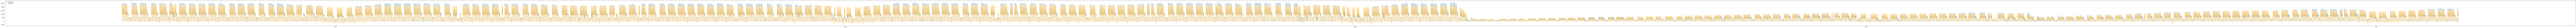

<IPython.core.display.Javascript object>

In [92]:
forecast = model.predict(pred)
fig = plt.gcf()
fig.set_size_inches(500, 5)
plt.plot(demand_summary["ds"], demand_summary["y"], label="Observado")
plt.plot(forecast["ds"], forecast["yhat"], label="Modelado", color="orange")
plt.legend(loc="upper left")

In [93]:
fig.savefig("result.png")

<IPython.core.display.Javascript object>

In [94]:
pred = demand_summary.iloc[22000:25000].copy()

<IPython.core.display.Javascript object>

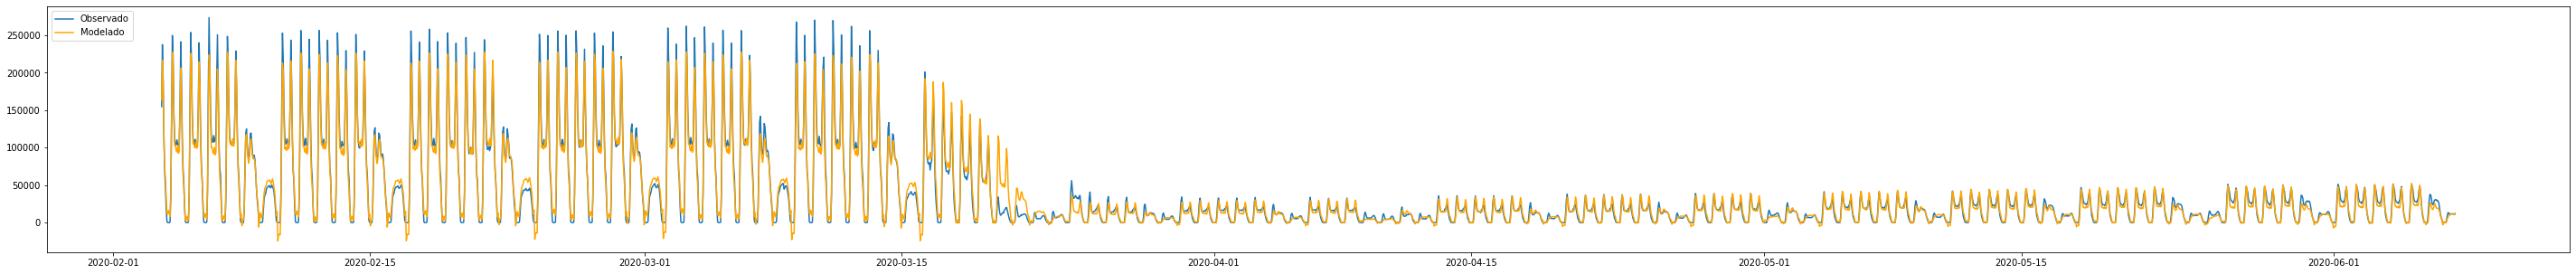

<IPython.core.display.Javascript object>

In [95]:
forecast = model.predict(pred)
fig = plt.gcf()
fig.set_size_inches(50, 5)
plt.plot(
    demand_summary.iloc[22000:25000]["ds"],
    demand_summary.iloc[22000:25000]["y"],
    label="Observado",
)
plt.plot(forecast["ds"], forecast["yhat"], label="Modelado", color="orange")
plt.legend(loc="upper left")

In [6]:
forecast_system = catalog.load("forecast_system")

2022-04-10 22:11:40,583 - kedro.io.data_catalog - INFO - Loading data from `forecast_system` (ParquetDataSet)...


<IPython.core.display.Javascript object>

In [7]:
dayly_seasonalities = ['weekday','saturday','sunday','holiday']

<IPython.core.display.Javascript object>

In [8]:
dayly_seasonalities_df = None

<IPython.core.display.Javascript object>

In [ ]:
for col in dayly_seasonalities:
    aux_df = forecast_system[['ds',col]].copy()
    aux_df['hour'] = aux_df['ds'].apply(lambda x: x.hour)
    aux_df.drop('ds',axis=1,inplace=True)
    aux_df.drop_duplicates(inplace=True)
    dayly_seasonalities_df = aux_df if dayly_seasonalities_df is None else pd.merge(dayly_seasonalities_df,aux_df,on='hour')

In [ ]:
dayly_seasonalities_df

,weekday
hour,
0,-1.145055
1,-1.103257
2,-1.153894
3,-1.123025
4,-0.737248
...,...
19,0.067843
20,-0.331205
21,-0.571411


In [10]:
for c in forecast_system.columns:
    print(c)

ds
trend
yhat_lower
yhat_upper
trend_lower
trend_upper
Ascensión del señor [Ascension of Jesus](Observed)
Ascensión del señor [Ascension of Jesus](Observed)_lower
Ascensión del señor [Ascension of Jesus](Observed)_upper
Año Nuevo [New Year's Day]
Año Nuevo [New Year's Day]_lower
Año Nuevo [New Year's Day]_upper
Batalla de Boyacá [Battle of Boyacá]
Batalla de Boyacá [Battle of Boyacá]_lower
Batalla de Boyacá [Battle of Boyacá]_upper
Corpus Christi [Corpus Christi](Observed)
Corpus Christi [Corpus Christi](Observed)_lower
Corpus Christi [Corpus Christi](Observed)_upper
Día de San José [Saint Joseph's Day]
Día de San José [Saint Joseph's Day]_lower
Día de San José [Saint Joseph's Day]_upper
Día de San José [Saint Joseph's Day](Observed)
Día de San José [Saint Joseph's Day](Observed)_lower
Día de San José [Saint Joseph's Day](Observed)_upper
Día de Todos los Santos [All Saint's Day]
Día de Todos los Santos [All Saint's Day]_lower
Día de Todos los Santos [All Saint's Day]_upper
Día de Todos